In [1]:
import json
import torch
import os
from dataset import DatasetPreprocessing, create_label_map, show_sample
from model import BirdClassifier
from helper import train_model, evaluate_model, load_model, predict, predict_online
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
DEBUG = False
NUM_EPOCHS = 30

In [3]:
label_map = create_label_map(file_path='data/train.txt')
print(f'Number of classes: {len(label_map)}')
train_dataset = DatasetPreprocessing(dataset_path='data/train', 
                                annotation_file='data/train.txt', 
                                label_map=label_map, 
                                debug=DEBUG)
test_dataset = DatasetPreprocessing(dataset_path='data/test', 
                                    annotation_file='data/test.txt', 
                                    label_map=label_map, 
                                    debug=DEBUG)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Number of classes: 200


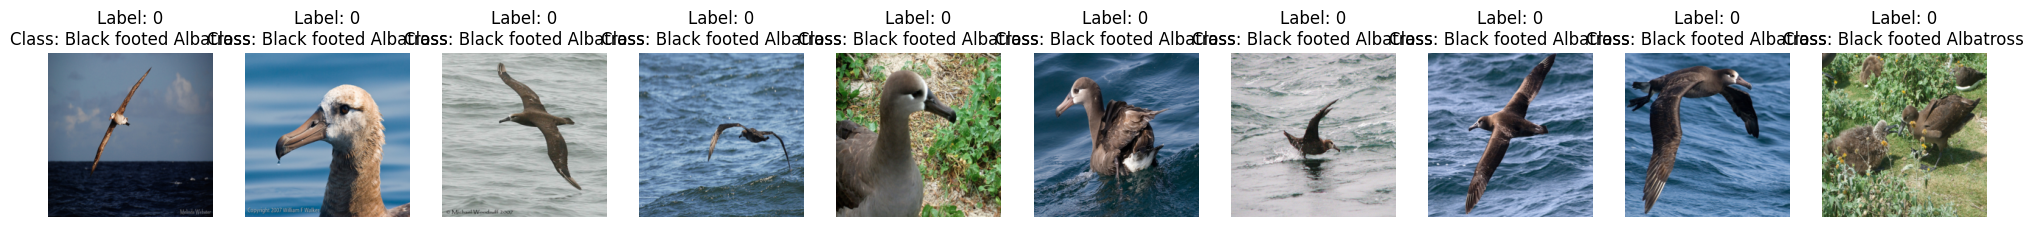

In [4]:
show_sample(train_dataset, num_samples=10)

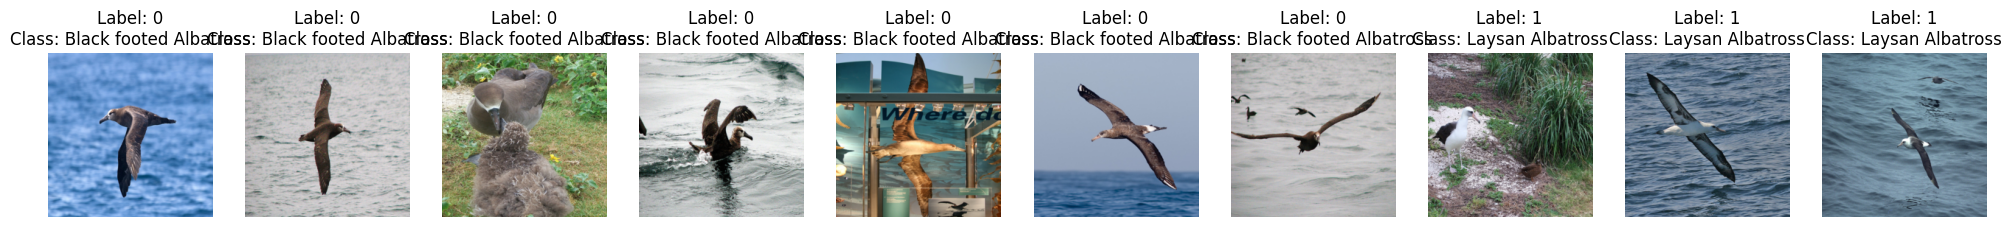

In [5]:
show_sample(test_dataset, num_samples=10)

In [6]:
def run(train=False, label_map=None, train_loader=None, val_loader=None, num_epochs=None):
    if label_map is None:
        raise ValueError("label_map must be provided")
    if train and (train_loader is None or val_loader is None or num_epochs is None):
        raise ValueError("Training parameters must be provided if training is to be performed")

    model_path = 'models/checkpoint.pt'
    if os.path.exists(model_path):
        print('Loading model from checkpoint')
        model = load_model(BirdClassifier(num_classes=len(label_map)), model_path)
    else:
        print(f'Load model from scratch')
        model = BirdClassifier(num_classes=len(label_map))

    if train:
        print('Training model')
        model = train_model(model, train_loader, val_loader, num_epochs=num_epochs)

    return model

In [7]:
model = run(train=False, label_map=label_map, train_loader=train_loader, val_loader=val_loader, num_epochs=NUM_EPOCHS)

Loading model from checkpoint


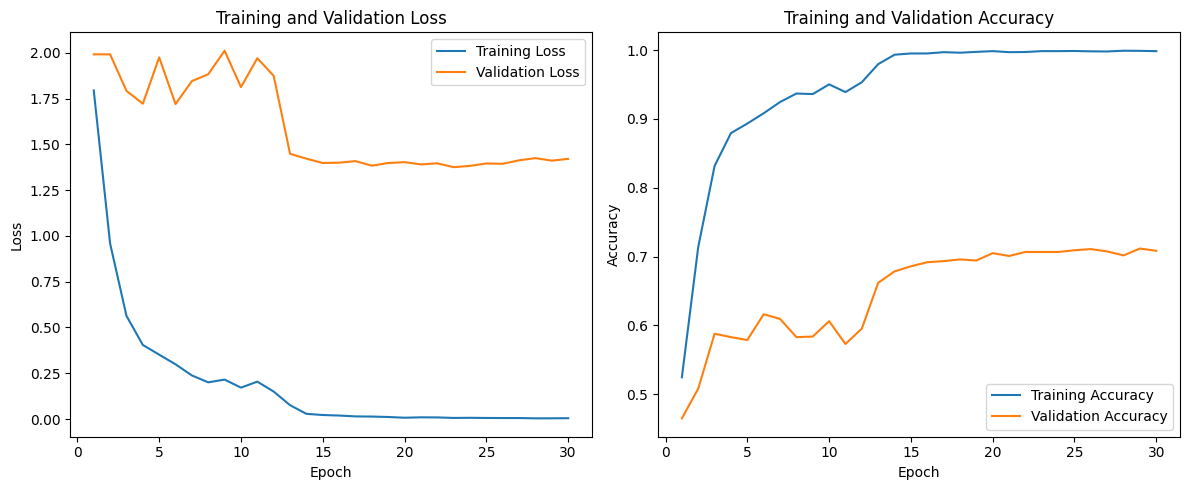

In [8]:
# Load the data from CSV file
data = pd.read_csv('training_metrics.csv')

# Function to extract float from tensor string
def extract_float_from_tensor(tensor_string):
    start = tensor_string.find("(") + 1
    end = tensor_string.find(",")
    return float(tensor_string[start:end])

# Apply the function to extract floats from tensor strings
data['Train Accuracy'] = data['Train Accuracy'].apply(extract_float_from_tensor)
data['Validation Accuracy'] = data['Validation Accuracy'].apply(extract_float_from_tensor)

# Plotting
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(data['Epoch'], data['Train Loss'], label='Training Loss')
plt.plot(data['Epoch'], data['Validation Loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(data['Epoch'], data['Train Accuracy'], label='Training Accuracy')
plt.plot(data['Epoch'], data['Validation Accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
evaluate_model(model, val_loader, num_classes=len(label_map))

Top-1 Accuracy: 0.7068
Average Accuracy Per Class: 0.7002


{'top_1_accuracy': 0.7068106312292359,
 'average_accuracy_per_class': 0.7001964285714287}

In [10]:
image_path = 'data/test/0325.jpg'
predicted = predict(model, image_path, label_map)

predicted: tensor([54])
predicted_class_index: 54
predicted_class_name: Evening Grosbeak


In [12]:
urls = {
    "Black footed Albatross": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6zzYyaoo-AfrGJYPLi_oQ6-0rY4pYKREPAkMEBktUtQ&s",
    "Horned Grebe": "https://leesbirdblog.files.wordpress.com/2014/07/pod-podi-horned-grebe-podiceps-auritus-c2a9wiki.jpg",
    "Indigo Bunting": "https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcR3JSKD9bUrn8SFlTx2IXhNYxkPpaoDz6S7fMdh2EE33UoMEf3E_5xcWrC7Bn_fNYVWirt-U7dkPdZwxKM",
    "White breasted Nuthatch": "https://holdenfg.org/wp-content/uploads/2021/03/nuthatch-351395-1920x1153.jpg",
    "Louisiana Waterthrush": "https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcT4xKBehNcCiOSy2zp9M6ZBDfok3F4aZPIalsuqqEf90bQnBmvs"
}

for label, url in urls.items():
    predicted, img = predict_online(model, url, label_map)
    print(f'Correct label: {label}, Predicted label: {predicted}\n | Correct: {bool(label == predicted)}\n | URL: {url}\n')
    # plt.imshow(img)
    # plt.show()

Correct label: Black footed Albatross, Predicted label: Black footed Albatross
 | Correct: True
 | URL: https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT6zzYyaoo-AfrGJYPLi_oQ6-0rY4pYKREPAkMEBktUtQ&s

Correct label: Horned Grebe, Predicted label: Horned Grebe
 | Correct: True
 | URL: https://leesbirdblog.files.wordpress.com/2014/07/pod-podi-horned-grebe-podiceps-auritus-c2a9wiki.jpg

Correct label: Indigo Bunting, Predicted label: Indigo Bunting
 | Correct: True
 | URL: https://encrypted-tbn0.gstatic.com/licensed-image?q=tbn:ANd9GcR3JSKD9bUrn8SFlTx2IXhNYxkPpaoDz6S7fMdh2EE33UoMEf3E_5xcWrC7Bn_fNYVWirt-U7dkPdZwxKM

Correct label: White breasted Nuthatch, Predicted label: White breasted Nuthatch
 | Correct: True
 | URL: https://holdenfg.org/wp-content/uploads/2021/03/nuthatch-351395-1920x1153.jpg

Correct label: Louisiana Waterthrush, Predicted label: Louisiana Waterthrush
 | Correct: True
 | URL: https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcT4xKBehNcCiOSy2zp9M6ZBDfok3F4aZPIa